# Vigilant Asset Allocation (VAA)

https://drive.google.com/drive/folders/0B0d_RbWn3rcLdzExX1g1XzJOREk

# Imports

In [1]:
import os

os.chdir('C:\\Users\\scuba\\Google Drive\\PycharmProjects\\SimpleBacktester')
os.getcwd()

from backtest_helpers.endpoints import endpoints
from backtest_helpers.backtest import backtest
from backtest_helpers.finhelpers3 import show_return_table

In [2]:
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
import pytz
import itable
import ffn
import talib

%matplotlib inline

In [3]:
# dummy logger
class Log() :
    pass
    def info (self, s) :
        print ('{} INFO : {}'.format(datetime.today().utcnow().replace(tzinfo=pytz.utc),s))
        pass
    def debug (self, s) :
        print ('{} DEBUG : {}'.format(datetime.today().utcnow().replace(tzinfo=pytz.utc)))
        pass
    def warn (self, s) :
        print ('{} WARNING : {}'.format(datetime.today().utcnow().replace(tzinfo=pytz.utc)))
        pass
        
log = Log()

# Set Portfolios

In [4]:
offensive = ['SPY','EFA','EEM','AGG']
defensive = ['LQD','IEF','SHY']

In [5]:
# Universe of 'risky' assets
N = len(offensive)
N

4

In [6]:
#if there are no X BAD assets how many assets do I invest in
TOP = 2
# How many bad assets are allowed (assets with negative return)
BAD = 1 

# Get Data

In [7]:
tickers = offensive + defensive

# Define which online source one should use
data_source = 'yahoo'

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '1986-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = web.DataReader(tickers, data_source, start_date, end_date)

panel_data

<class 'pandas.core.panel.Panel'>
Dimensions: 6 (items) x 6199 (major_axis) x 7 (minor_axis)
Items axis: Adj Close to Volume
Major_axis axis: 1993-01-29 00:00:00 to 2017-09-08 00:00:00
Minor_axis axis: AGG to SPY

In [8]:
data = panel_data['Adj Close'].sort_index(ascending=True)
inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])
inception_dates

,inception
AGG,2003-09-29
EEM,2003-04-14
EFA,2001-08-27
IEF,2002-07-30
LQD,2002-07-30
SHY,2002-07-30
SPY,1993-01-29


In [9]:
prices = data.copy().dropna()
prices[:5]

,AGG,EEM,EFA,IEF,LQD,SHY,SPY
Date,,,,,,,
2003-09-29,63.477432,11.909451,26.920233,55.624092,59.388885,64.395943,76.525749
2003-09-30,63.806713,11.871896,26.579468,56.162373,59.782871,64.528534,75.782692
2003-10-01,63.775661,12.183693,27.451818,56.411598,59.954800,64.538681,77.397682
2003-10-02,63.676296,12.358370,27.408653,56.208843,59.724426,64.538681,77.678185
2003-10-03,63.216534,12.480646,27.808483,55.430408,58.893787,64.374710,78.390915


In [10]:
end_points = endpoints(period='M', trading_days=prices.index)
prices_m = prices.loc[end_points]
prices_m[:5]

,AGG,EEM,EFA,IEF,LQD,SHY,SPY
Date,,,,,,,
2003-09-30,63.806713,11.871896,26.579468,56.162373,59.782871,64.528534,75.782692
2003-10-31,63.210323,12.961880,28.305992,55.338856,59.027767,64.265388,79.839111
2003-11-28,63.421680,13.205552,29.021589,55.351337,59.209076,64.227089,80.711067
2003-12-31,64.042702,14.392002,31.557365,56.480602,60.731926,64.924973,84.771881
2004-01-30,64.324799,14.740541,31.912670,57.054070,61.473396,65.003784,86.447800


# Momemtum Score

In [11]:
p = prices_m
mom_scores = (12 * p.pct_change(1) + 4 * p.pct_change(3) + 2 * p.pct_change(6) + p.pct_change(12)).dropna()    # W13612 rule

In [31]:
mom_scores[-5:]

,AGG,EEM,EFA,IEF,LQD,SHY,SPY
Date,,,,,,,
2017-05-31,0.213066,1.295208,1.321543,0.232790,0.381694,0.037309,0.659177
2017-06-30,0.104897,0.933209,0.784760,0.005587,0.277331,0.003632,0.560556
2017-07-31,0.124481,1.678413,1.047724,0.086669,0.301958,0.039191,0.761712
2017-08-31,0.225103,1.272810,0.541541,0.280729,0.256476,0.054020,0.429456
2017-09-08,0.151659,0.862113,0.626036,0.222012,0.157201,0.048732,0.294432


# Weights

If all four of the offensive assets exhibit positive momentum scores, select the offensive asset with the highest score and allocate 100% of the portfolio to that asset at the close.

If any of the four offensive assets exhibit negative momentum scores, select the defensive asset (LQD, IEF or SHY) with the highest score (regardless of whether the score is > 0) and allocate 100% of the portfolio to that asset at the close.

In [154]:
TOP_DEFENSIVE = 1
TOP_OFFENSIVE = 1

weights = pd.DataFrame(0., index=mom_scores.index, columns=mom_scores.columns) 
for row in range(len(mom_scores)):
    if sum(mom_scores.iloc[row][offensive].values<0)==0:
        weights.iloc[row] = mom_scores.iloc[row][offensive].rank(ascending=False)
        weights.iloc[row] = [1.0 / TOP_OFFENSIVE if weights.iloc[row][i] <= TOP_OFFENSIVE 
                             else 0. for i in range(len(weights.iloc[row]))]
    else: 
        weights.iloc[row] = mom_scores.iloc[row][defensive].rank(ascending=False)
        weights.iloc[row] = [1.0 / TOP_DEFENSIVE if weights.iloc[row][i] <= TOP_DEFENSIVE  
                             else 0. for i in range(len(weights.iloc[row]))]        

In [155]:
weights[:5]

,AGG,EEM,EFA,IEF,LQD,SHY,SPY
Date,,,,,,,
2004-09-30,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2004-10-29,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2004-11-30,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2004-12-31,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2005-01-31,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Backtest

In [156]:
p_value, p_holdings, p_weights = backtest(prices, weights, capital=10000., offset=1, commission=0.)

FIRST BUY DATE = 2004-10-01 00:00:00



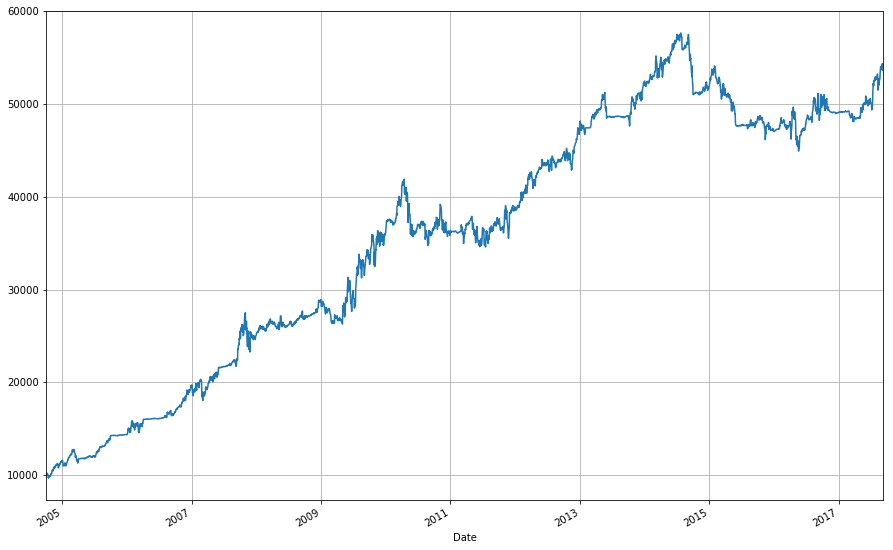

In [157]:
p_value.plot(figsize=(15, 10), grid=True)

In [158]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 2004-10-01 00:00:00 - 2017-09-08 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
439.77%             0.96  13.92%  -22.07%

Annualized Returns:
mtd    3m     6m      ytd    1y     3y      5y     10y    incep.
-----  -----  ------  -----  -----  ------  -----  -----  --------
0.13%  7.21%  11.32%  9.90%  6.15%  -1.69%  4.25%  9.52%  13.92%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.96     1.14       1.00
mean    14.14%   13.77%     13.26%
vol     14.80%   12.12%     13.27%
skew    -0.03    0.50       0.09
kurt    8.67     2.29       -0.82
best    7.06%    13.90%     36.08%
worst   -8.13%   -8.63%     -9.12%

Drawdowns:
max      avg       # days
-------  ------  --------
-22.07%  -1.81%      25.2

Misc:
---------------  ------
avg. up month    2.74%
avg. down month  -2.19%
up year %        84.62%
12m up %         8

In [148]:
show_return_table(p_value)

# SCRATCHPAD